In [1]:
import networkx as nx
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

In [3]:
from dask.distributed import Client, progress
import dask
client = Client()
client

/Users/michaellin/anaconda3/envs/dask-tutorial/lib/python3.7/site-packages/distributed/dashboard/core.py:79: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)


Client Scheduler: tcp://127.0.0.1:59006 Dashboard: http://127.0.0.1:59007/status,Cluster Workers: 4 Cores: 4 Memory: 8.59 GB


In [4]:
#################################################################################
############################### Helper Functions  ###############################
#################################################################################

def set_influence(G, value, node=None):
    '''
        Set influence of a node in a network G or
        set influence of all nodes to value.
        G      ::  a networkx graph
        node   ::  a reference to a node in G
        value  ::  an integer 0 or 1
    '''
    if node:
        G.nodes[node][label] = value
    else:
        influence_attrib = { i : value for i in range(N) }
        nx.set_node_attributes(G,influence_attrib, label)
        
def get_is_influenced(G, node):
    return G.nodes[node][label]
        
def get_number_influenced(G):
    '''
        Get the number of influenced nodes.
    '''
    return sum(nx.get_node_attributes(G, label).values())

def check_can_influence(G, node, q):
    '''
        Determines whether a node is influenced by
        its neighbours. (Threshold Check)
    '''
    if get_is_influenced(G, node) == 1:
        return False
    
    friends = list(G.neighbors(node))
    num_friends = len(friends)
    
    if num_friends == 0:
        return False
    
    num_influenced = sum([1 for friend in friends if G.nodes[friend][label] == 1])
    
    if num_influenced/num_friends > q:
        return True
    return False

#################################################################################
########################## Simulation Helper Functions ##########################
#################################################################################

def spread_influence(G, current_node, phi):
    '''
        Recursive function to spread influence 
        from current_node in G.
    '''
    
    ## Not interesting
    if get_is_influenced(G, current_node) == 0 and not check_can_influence(G, current_node, phi):
        return
    else:
        set_influence(G, 1, current_node)
        ## Find uninfluenced friends
        friends = list(G.neighbors(current_node))
        targets = [friend for friend in friends if G.nodes[friend][label] == 0]
        
        for friend in targets:
            spread_influence(G, friend, phi)
        
def get_vulnerable(G, phi):
    '''
        Check for vulnerable nodes.
        Return list of vulnerable nodes.
    '''
    vulnerable = []
    for node in G.nodes():
        if check_can_influence(G, node, phi):
            vulnerable.append(node)
    return vulnerable
        
def simulate_spread(G, nodes, phi):
    '''
        Simulates the spread of influence starting from each 
        node in nodes and returns a list containing the 
        number of influenced from starting at each node.
    '''
    S = []
    for node in nodes:
        G_tmp = G.copy()
        set_influence(G_tmp, 1, node)
        spread_influence(G_tmp, node, phi)
        
        vulnerable = get_vulnerable(G_tmp, phi)

        while len(vulnerable) != 0:
            for vul in vulnerable:
                spread_influence(G_tmp, vul, phi)
            vulnerable = get_vulnerable(G_tmp, phi)

        S.append(get_number_influenced(G_tmp))
        
    return S

In [14]:
def run_simulation(probability):
    G = nx.erdos_renyi_graph(N, probability, directed)
    set_influence(G, 0)
    ## Retrieve influential nodes - top q% and non-influential nodes
    degree_ordered_nodes = sorted(list(G.nodes()), key=lambda x: G.degree(x), reverse=True)
    influential_nodes = degree_ordered_nodes[:int(q*N)]
    normal_nodes = degree_ordered_nodes[int(q*N):]
    ## Simulation
    influential = simulate_spread(G, influential_nodes, phi)
    normal = simulate_spread(G, normal_nodes, phi)
    ## Store results
    S_influential = np.mean(influential)
    S_normal = (np.mean(normal))
    
    return [S_influential, S_normal]

In [85]:
## Parameters

N = 1000
q = 0.1   
phi = 0.18
max_n_avg = 7
increment = 0.2
num_simulations = 100
label = 'is_influenced'
directed = True

n_avg = np.arange(1, max_n_avg, increment)
p = [avg/(N-1) for avg in n_avg]
n = len(p)
# S = np.zeros([num_simulations, n, 2])
S = []

In [86]:
%%time

S = []
for i in tqdm(range(num_simulations)):
    for j in range(n):
        S.append(dask.delayed(run_simulation)(p[j]))

results = dask.compute(S)

100%|██████████| 100/100 [00:00<00:00, 115.63it/s]


CPU times: user 35.2 s, sys: 3.1 s, total: 38.3 s
Wall time: 2min 47s


In [87]:
S = np.reshape(np.asarray(results)[0], (num_simulations, n, 2))

In [88]:
S_influential = S[:,:,0]
S_normal = S[:,:,1]

In [89]:
##########################
### Processing Results ###
##########################
names = ["Influential", "Normal"]

# Number of Nodes of Network Influenced
N_influential = np.apply_along_axis(np.mean, 0, S_influential)
N_normal = np.apply_along_axis(np.mean, 0, S_normal)

# Proportion of Network Influenced
P_influential = [x/N for x in N_influential]
P_normal = [x/N for x in N_normal]

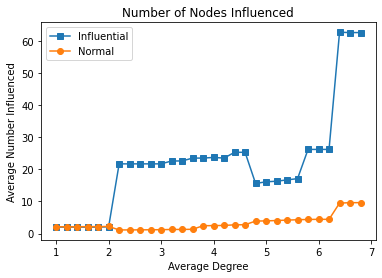

In [90]:
############
### Pots ###
############

plt.plot(n_avg, N_influential, "-s")
plt.plot(n_avg, N_normal, "-o")
plt.ylabel("Average Number Influenced")
plt.xlabel("Average Degree")
plt.title("Number of Nodes Influenced")
plt.legend(names)

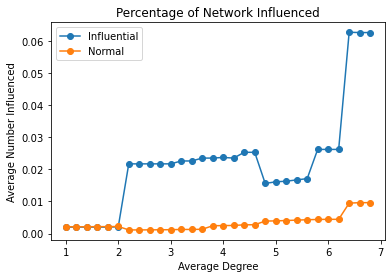

In [91]:
plt.plot(n_avg, P_influential, "-o")
plt.plot(n_avg, P_normal, "-o")
plt.ylabel("Average Number Influenced")
plt.xlabel("Average Degree")
plt.title("Percentage of Network Influenced")
plt.legend(names)

In [52]:
np.toresults[0]

[81.4, 36.12222222222222]